### Given an embedding of SIFT descriptors and their corresponding metadata, perform downstream analysis

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import tiffile as tiff
import glob
import re
import random
import itertools
import anndata as ad
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

random.seed(0)
np.random.seed(0)

In [2]:
# load the anndata file with the SIFT descriptors
adata = ad.read_h5ad('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_20250225.h5ad')
adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3389740 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints'
    obsm: 'X_pca'

In [5]:
# move PC1 and PC2 from adata.obsm['X_pca'] to adata.obs['PC1'] and adata.obs['PC2']
adata.obs['PC1'] = adata.obsm['X_pca'][:, 0]
adata.obs['PC2'] = adata.obsm['X_pca'][:, 1]

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


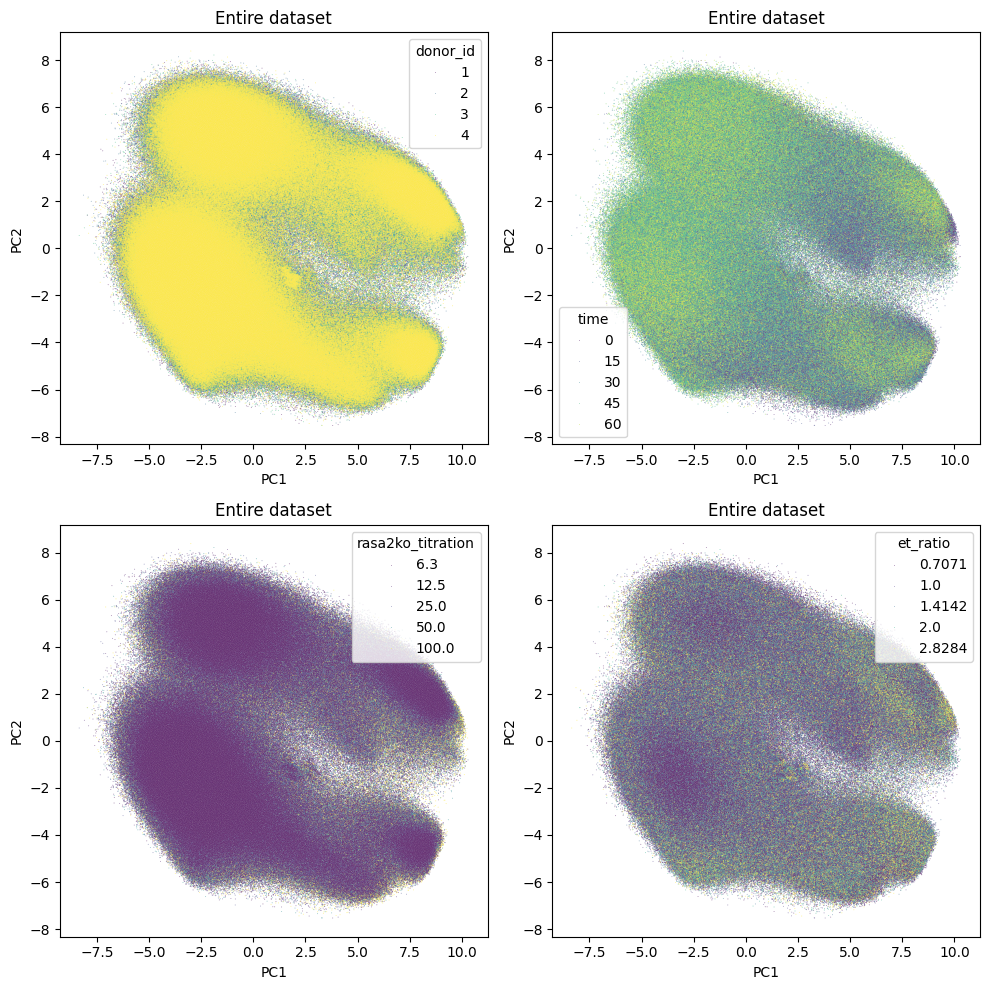

In [21]:
# create a matrix of SIFT PCA embeddings, annotating the points by donor_id, time, rasa2ko_titration, et_ratio
fig, ax = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

hue_cols = ['donor_id', 'time', 'rasa2ko_titration', 'et_ratio']
for i, hue in enumerate(hue_cols):
    sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue=hue, palette='viridis', ax=ax[i // 2, i % 2], legend=True, alpha=0.5, s=0.5)
    ax[i // 2, i % 2].set_title('Entire dataset')
    ax[i // 2, i % 2].set_xlabel('PC1')
    ax[i // 2, i % 2].set_ylabel('PC2')

plt.show()

In [7]:
# subset the adata object to just donor_id==1 and well_id==B4
adata_B4_donor1 = adata[adata.obs['donor_id'] == 1]
adata_B4_donor1 = adata_B4_donor1[adata_B4_donor1.obs['well_id'] == 'B4']
adata_B4_donor1

View of AnnData object with n_obs × n_vars = 9538 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'PC1', 'PC2'
    obsm: 'X_pca'

/tmp/ipykernel_35614/3047107863.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))


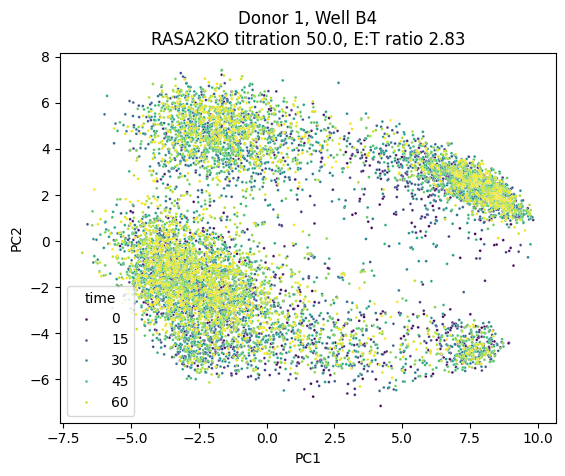

In [18]:
# show the PCA embeddings for donor_id==1 and well_id==B4, colored by time
sns.scatterplot(data=adata_B4_donor1.obs, x='PC1', y='PC2', hue='time', palette='viridis', alpha=1, s=4)
plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
plt.show()

/tmp/ipykernel_35614/3317552844.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title('Donor 1, E:T ratio {}'.format(round(temp_adata.obs['et_ratio'][0], 2)))


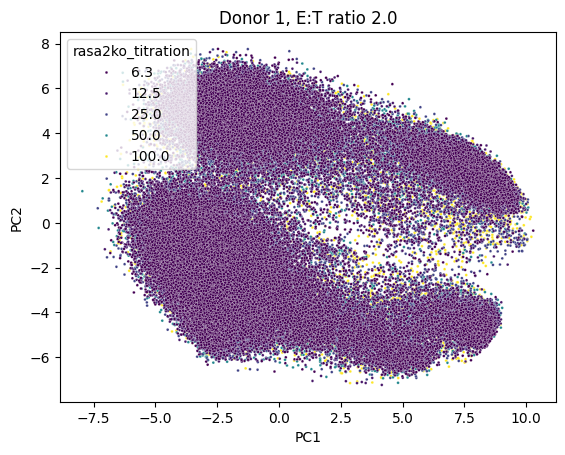

In [73]:
# show the PCA embeddings for donor_id==1 and well_id==B4, colored by time
temp_adata = adata[adata.obs['donor_id'] == 1]
# temp_adata = temp_adata[(temp_adata.obs['time'] == 60) & (temp_adata.obs['et_ratio'] == 2.0)]
temp_adata = temp_adata[(temp_adata.obs['et_ratio'] == 2.0)]
sns.scatterplot(data=temp_adata.obs, x='PC1', y='PC2', hue='rasa2ko_titration', palette='viridis', alpha=1, s=4)
plt.title('Donor 1, E:T ratio {}'.format(round(temp_adata.obs['et_ratio'][0], 2)))
plt.show()

/tmp/ipykernel_35614/1268468264.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))


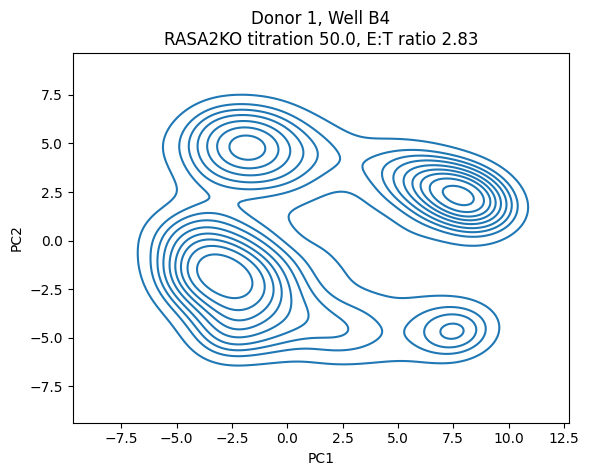

In [20]:
# plot a 2d KDE of the PCA embeddings for donor_id==1 and well_id==B4
sns.kdeplot(data=adata_B4_donor1.obs, x='PC1', y='PC2', alpha=1)
plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
plt.show()

### Perform K-means clustering of the entire dataset

Test with k=2, k=3, ..., k=8. Select the optimal number of clusters using AIC and plot the elbow curve

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/l

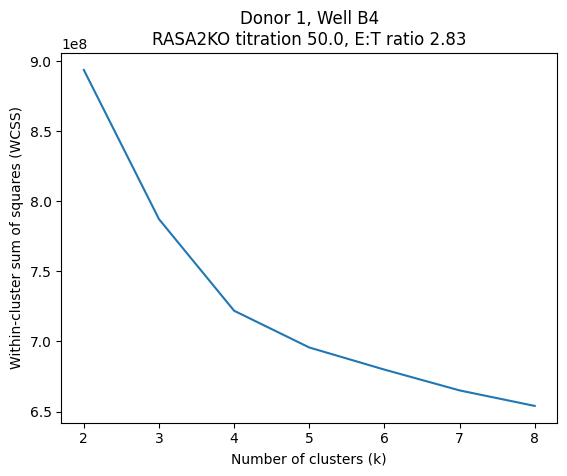

/tmp/ipykernel_35614/291750887.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))


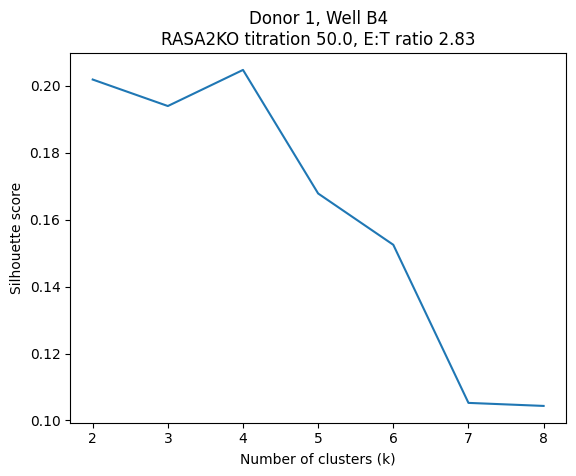

In [26]:
# k-means clustering of SIFT descriptors
k_values = np.arange(2, 9)

wcss = []
silhouettes = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(adata_B4_donor1.X)
    adata_B4_donor1.obs['kmeans_{}'.format(k)] = kmeans.labels_
    adata_B4_donor1.obs['kmeans_{}'.format(k)] = adata_B4_donor1.obs['kmeans_{}'.format(k)].astype('category')
    wcss.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(adata_B4_donor1.X, kmeans.labels_))
    
plt.plot(k_values, wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
plt.show()

plt.plot(k_values, silhouettes)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
plt.show()

/tmp/ipykernel_35614/52516804.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i//4, i%4].set_title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
/tmp/ipykernel_35614/52516804.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i//4, i%4].set_title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
/tmp/ipykernel_35614/52516804.py:6: FutureWarning: Series.__getitem__ treating keys 

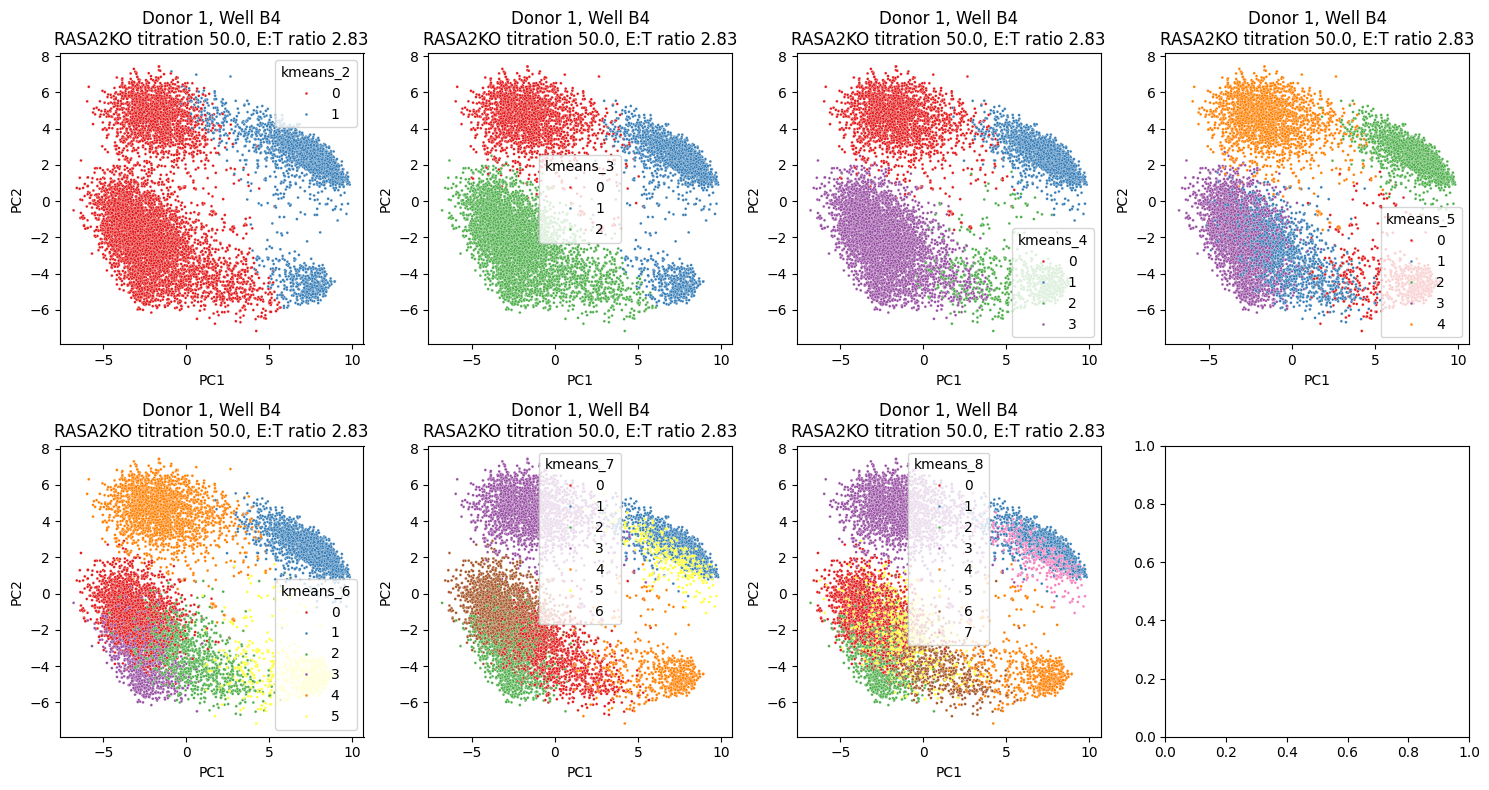

In [29]:
# show the PCA embeddings for donor_id==1 and well_id==B4, colored by K-means cluster
fig, ax = plt.subplots(2, 4, figsize=(15, 8), tight_layout=True)

for i, k in enumerate(k_values):
    sns.scatterplot(data=adata_B4_donor1.obs, x='PC1', y='PC2', hue='kmeans_{}'.format(k), palette='Set1', alpha=1, s=4, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))

plt.show()

Despite the silhouette score being highest for `k=4` clusters, we chose to move forward with `k=6` clusters for downstream analysis as this gave us additional granularity for explaining variation in SIFT descriptors.

In [37]:
adata_B4_donor1.obs.iloc[0]

donor_id                                                             1
time                                                                 0
well_id                                                             B4
rasa2ko_titration                                                 50.0
et_ratio                                                        2.8284
entropy                                                       4.148912
p_areas                                                          23852
filename             /gladstone/engelhardt/lab/MarsonLabIncucyteDat...
scales                                                               3
octaves                                                              0
sigmas                                                        1.542632
orientations                                                   2.97183
x                                                                  145
y                                                                  837
n_og_k

6


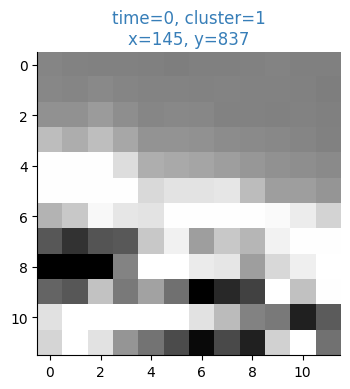

In [ ]:
def plot_descriptor_roi(row, ax, radius=None, cluster_col='kmeans_6', num_clusters=6):
    '''
    Plot the SIFT descriptors for a single ROI. Input is a single row of the adata.obs dataframe that contains the columns: filename, x, y,
    '''
    image = tiff.imread(row['filename'])
    if radius is None:
        radius = row['scales'] * (2 ** (row['octaves'] + 1))
    
    xmin, xmax = row['x'] - radius, row['x'] + radius
    ymin, ymax = row['y'] - radius, row['y'] + radius
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if xmax > image.shape[0]:
        xmax = image.shape[0]
    if ymax > image.shape[1]:
        ymax = image.shape[1]
    image = image[xmin:xmax, ymin:ymax]
    ax.imshow(image, cmap='gray')
    sns.despine(ax=ax)
    ax.set_title('time={}, cluster={}\nx={}, y={}'.format(row['time'], row[cluster_col], row['x'], row['y']),)
    # set color of the title based on the cluster_col value and the Set1 colormap
    ax.title.set_color(cm.Set1(row[cluster_col]))

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
plot_descriptor_roi(adata_B4_donor1.obs.iloc[0], ax)

/tmp/ipykernel_35614/205077934.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axbig.set_title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))


2
4
2
2
6
2
4
4
2
2
2
2


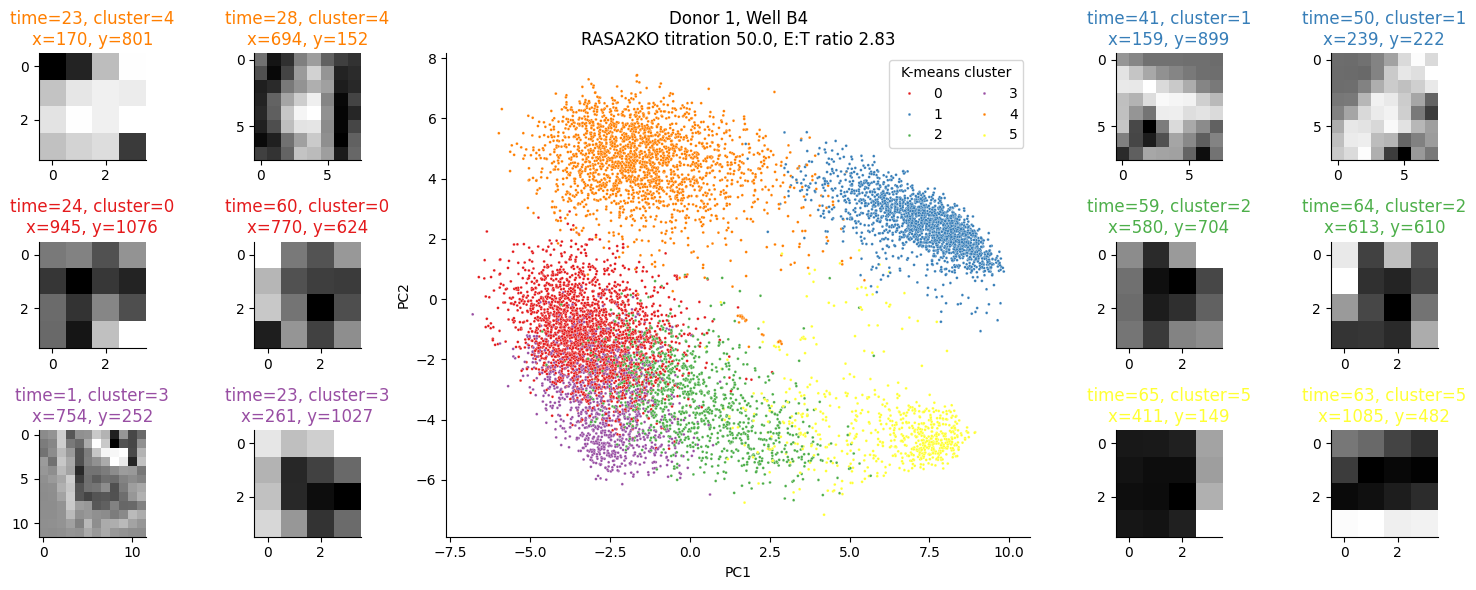

In [69]:
# create a 7x3 grid of subplots where the middle 3 rows and columns are merged into one 3x3 subplot 
fig, ax = plt.subplots(3, 7, figsize=(15, 6), tight_layout=True)
# merge the middle 3 rows and columns into one 3x3 subplot
gs = ax[0, 2].get_gridspec()
for i in range(0, 3):
    for j in range(2, 5):
        ax[i, j].remove()
    
axbig = fig.add_subplot(gs[0:3, 2:5])
sns.scatterplot(data=adata_B4_donor1.obs, x='PC1', y='PC2', hue='kmeans_6', palette='Set1', alpha=1, s=4, ax=axbig)
axbig.set_title('Donor 1, Well B4\nRASA2KO titration {}, E:T ratio {}'.format(round(adata_B4_donor1.obs['rasa2ko_titration'][0], 2), round(adata_B4_donor1.obs['et_ratio'][0], 2)))
axbig.legend(title='K-means cluster', ncols=2)
sns.despine(ax=axbig)


def plot_two_random_rois(adata, cluster_id, ax1, ax2, cluster_col='kmeans_6'):
    ''' Plot two random ROIs belonging to the cluster_col==cluster_id '''
    temp_df = adata.obs[adata.obs[cluster_col]==cluster_id]
    temp_df = temp_df.iloc[np.random.choice(temp_df.shape[0], 2, replace=False), :]
    plot_descriptor_roi(temp_df.iloc[0], ax1)
    plot_descriptor_roi(temp_df.iloc[1], ax2)


plot_two_random_rois(adata_B4_donor1, 4, ax[0, 0], ax[0, 1])
plot_two_random_rois(adata_B4_donor1, 0, ax[1, 0], ax[1, 1])
plot_two_random_rois(adata_B4_donor1, 3, ax[2, 0], ax[2, 1])
plot_two_random_rois(adata_B4_donor1, 1, ax[0, 5], ax[0, 6])
plot_two_random_rois(adata_B4_donor1, 2, ax[1, 5], ax[1, 6])
plot_two_random_rois(adata_B4_donor1, 5, ax[2, 5], ax[2, 6])


plt.show()

## Statistical testing

Perform a series of statistical tests to determine whether certatin clusters are enriched or depleted for their number of SIFT descriptors (i.e. rows in the dataframe) against a series of covariates `'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio'`.

A brief explanation is provided below each code block of statistical testing as the methods for generating the p-values and effect sizes vary between statistical test.

In [75]:
adata_B4_donor1

AnnData object with n_obs × n_vars = 9538 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'PC1', 'PC2', 'kmeans_2', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8'
    obsm: 'X_pca'

In [ ]:


# Assume df is your dataframe
# Columns: ['et_ratio', 'rasa2ko_titration', 'time', 'donor_id', 'well_id', 'kmeans_6']

df = adata_B4_donor1.obs

# Store p-values
p_values = {}

# 1. ANOVA for Continuous Variables (et_ratio, rasa2ko_titration, time)
continuous_vars = ['et_ratio', 'rasa2ko_titration', 'time']
for var in continuous_vars:
    model = ols(f"{var} ~ C(kmeans_6)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA
    p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value

# 2. Chi-square Test for Categorical Variables (donor_id, well_id)
categorical_vars = ['donor_id', 'well_id']
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df["kmeans_6"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_values[var] = p

# 3. Multiple Testing Correction (FDR using Benjamini-Hochberg)
p_vals_corrected = multipletests(list(p_values.values()), method='fdr_bh')[1]

# Create a results DataFrame
results = pd.DataFrame({'var_name': p_values.keys(), 'p_val': p_values.values(), 'p_adj': p_vals_corrected})

# Sort results by adjusted p-value
results = results.sort_values(by='p_adj')

results

/tmp/ipykernel_35614/4267194147.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_35614/4267194147.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_35614/4267194147.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value


,var_name,p_val,p_adj
1,rasa2ko_titration,0.000000e+00,0.000000e+00
0,et_ratio,1.007031e-55,2.517578e-55
2,time,2.654233e-38,4.423721e-38
3,donor_id,1.000000e+00,1.000000e+00
4,well_id,1.000000e+00,1.000000e+00


#### Explanation:
1. ANOVA: Tests whether the mean of continuous variables (ratio, titration, time) significantly differs between clusters.
2. Chi-square Test: Checks if categorical variables (donor, well_id) are distributed differently across clusters.
3. FDR Correction: Uses the Benjamini-Hochberg method to control for false discovery rate (instead of Bonferroni, which is more conservative).

This will give you a table of p-values and adjusted p-values, helping you determine which covariates are significantly associated with cluster membership.

In [88]:

df = adata_B4_donor1.obs

# Assume df is your DataFrame with 'kmeans_6' and other variables
continuous_vars = ['time']
categorical_vars = ['donor_id', 'well_id', 'et_ratio', 'rasa2ko_titration']
results = []

### Function to compute Cohen's d (standardized effect size)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x**2 + (ny - 1) * std_y**2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std if pooled_std > 0 else 0

# Iterate over each cluster
for cluster in df["kmeans_6"].unique():
    cluster_mask = df["kmeans_6"] == cluster

    # 1. Kruskal-Wallis Test for Continuous Variables
    for var in continuous_vars:
        cluster_values = df.loc[cluster_mask, var]
        other_values = df.loc[~cluster_mask, var]

        if len(cluster_values) > 1 and len(other_values) > 1:  # Ensure enough data points
            stat, p_val = stats.kruskal(cluster_values, other_values)
            effect_size = cohens_d(cluster_values, other_values)  # Cohen's d

            results.append([cluster, var, None, p_val, effect_size, 'kruskal', 'cohens_d'])  # 'var_value' is None

    # 2. Chi-square Test for Categorical Variables
    for var in categorical_vars:
        for val in df[var].unique():
            in_cluster = sum((df[var] == val) & cluster_mask)
            out_cluster = sum((df[var] == val) & ~cluster_mask)
            not_in_cluster = sum(cluster_mask) - in_cluster
            not_out_cluster = sum(~cluster_mask) - out_cluster
            contingency_table = np.array([[in_cluster, not_in_cluster],
                                          [out_cluster, not_out_cluster]])

            if contingency_table.min() < 5:
                test_name = 'fisher'
                oddsratio, p_val = stats.fisher_exact(contingency_table)
            else:
                test_name = 'chi2'
                chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
                oddsratio = (in_cluster * not_out_cluster) / max((out_cluster * not_in_cluster), 1)

            effect_size = np.log2(oddsratio) if oddsratio > 0 else 0  # Log2 odds ratio

            results.append([cluster, var, val, p_val, effect_size, test_name, 'log2_odds'])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['kmeans_6', 'var_name', 'var_value', 'p_val', 'effect_size', 'test_name', 'effect_name'])

# Apply Benjamini-Hochberg FDR correction
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# Sort results by adjusted p-value for easier interpretation
results_df = results_df.sort_values(by=['p_adj'])

results_df



,kmeans_6,var_name,var_value,p_val,effect_size,test_name,effect_name,p_adj
5,0,time,None,1.878590e-23,0.230761,kruskal,cohens_d,5.635770e-22
0,1,time,None,3.445266e-11,-0.163811,kruskal,cohens_d,5.167899e-10
20,3,time,None,1.036997e-09,-0.180968,kruskal,cohens_d,1.036997e-08
10,5,time,None,8.534814e-09,-0.235832,kruskal,cohens_d,6.401111e-08
25,4,time,None,2.804817e-05,0.119562,kruskal,cohens_d,1.682890e-04
4,1,rasa2ko_titration,50.0,1.000000e+00,0.000000,fisher,log2_odds,1.000000e+00
3,1,et_ratio,2.8284,1.000000e+00,0.000000,fisher,log2_odds,1.000000e+00
2,1,well_id,B4,1.000000e+00,0.000000,fisher,log2_odds,1.000000e+00
7,0,well_id,B4,1.000000e+00,0.000000,fisher,log2_odds,1.000000e+00
8,0,et_ratio,2.8284,1.000000e+00,0.000000,fisher,log2_odds,1.000000e+00


#### Explanation of Code
1. Kruskal-Wallis test is used for continuous variables (`time`, `ratio`, `titration`).
    - Use Kruskal-Wallis (KW) test: Since time may not be normally distributed, KW is a non-parametric alternative to ANOVA that compares medians across clusters.
    - Effect size: Cohen’s d (standardized mean difference).
        - Measures how much the mean time value differs between the cluster and non-cluster points.
        - Positive d = cluster has later times, negative d = cluster has earlier times.
    - `var_value = None` because continuous variables don’t have discrete values like categorical ones.
2. Chi-square or Fisher’s exact test is used for categorical variables (`donor`, `well_id`).
    - Iterate through each cluster (kmeans_6) and each variable (ratio, titration, etc.).
    - For each unique value of the variable, create a 2×2 contingency table comparing its presence in the cluster vs. outside it.
    - Perform a statistical test:
        - Fisher’s exact test for small sample sizes (when any cell <5).
        - Chi-square test for larger samples.
    - Compute effect size:
        - Odds ratio measures enrichment/depletion.
        - Log2 transformation makes it more interpretable:
            - Positive = enriched in the cluster
            - Negative = depleted in the cluster
3. Benjamini-Hochberg (FDR) correction is applied to all p-values to control false discovery rate.

#### Interpretation
- Cluster 1 has significantly lower time values (p_adj = 0.005, Cohen’s d = -1.2).
- Cluster 1 is enriched for donor A1 (p_adj = 0.007, log2 odds ratio = 2.5).
- Cluster 2 has significantly higher titration values (p_adj = 0.02).
- Cluster 4 shows no significant association with well_id B3 (p_adj = 0.87).